#### ***Descripción Notebook 00***

In [4]:
# Auditar data/raw antes de preprocesar.
# Métricas mínimas por nivel y split: nº ficheros, bytes, frases, tokens.

#### ***Imports y configuración***

In [8]:
from pathlib import Path
import json, re
import pandas as pd
import numpy as np

pd.set_option("display.max_colwidth", 120)

def find_root():
    p = Path.cwd()
    for cand in [p, *p.parents]:
        if (cand / "data" / "raw").exists():
            return cand
    raise FileNotFoundError("No encuentro data/raw en este árbol de carpetas.")

#### ***Rutas y utilidades***

In [11]:
ROOT = find_root()
RAW_DIR = ROOT / "data" / "raw"
REPORTS = ROOT / "reports"
REPORTS.mkdir(parents=True, exist_ok=True)

NIVELES = ["easy", "medium", "hard"]
SPLITS = ["train", "validation"]

SENT_SPLIT = re.compile(r"(?<=[\.\?\!])\s+")
TOKEN_SPLIT = re.compile(r"\w+", flags=re.UNICODE)

def leer_txt(p: Path, max_chars=200_000):
    try:
        return p.read_text(encoding="utf-8", errors="replace")[:max_chars]
    except:
        return ""

def n_frases(t: str) -> int:
    t = t.strip()
    return 0 if not t else len(SENT_SPLIT.split(t))

def n_tokens(t: str) -> int:
    return len(TOKEN_SPLIT.findall(t.lower()))

#### ***Escaneo de ficheros RAW***

In [12]:
reg = []
for nivel in NIVELES:
    for split in SPLITS:
        base = RAW_DIR / nivel / split
        if not base.exists():
            continue
        files = list(base.rglob("*.txt")) + list(base.rglob("*.jsonl"))
        for fp in files:
            suffix = fp.suffix.lower()
            bytes_ = fp.stat().st_size
            sent = tok = 0

            if suffix == ".txt":
                txt = leer_txt(fp)
                sent = n_frases(txt)
                tok = n_tokens(txt)

            elif suffix == ".jsonl":
                s = t = 0
                with fp.open("r", encoding="utf-8", errors="replace") as f:
                    for line in f:
                        line = line.strip()
                        if not line:
                            continue
                        try:
                            obj = json.loads(line)
                        except:
                            continue
                        text = str(obj.get("text") or obj.get("sentence") or "")
                        s += 1
                        t += n_tokens(text)
                sent, tok = s, t

            reg.append({
                "level": nivel,
                "split": split,
                "path": str(fp.relative_to(ROOT)),
                "suffix": suffix,
                "bytes": bytes_,
                "n_sentences_raw": sent,
                "n_tokens_raw": tok,
            })

df_docs = pd.DataFrame(reg)
if df_docs.empty:
    print(f"Sin ficheros encontrados bajo {RAW_DIR}. Revisa niveles/splits y extensiones.")
else:
    df_docs = df_docs.sort_values(["level","split","path"])
    display(df_docs.head(10))
    print("Total ficheros:", len(df_docs))

,level,split,path,suffix,bytes,n_sentences_raw,n_tokens_raw
2616,easy,train,data/raw/easy/train/problem-1.txt,.txt,1827,18,309
3254,easy,train,data/raw/easy/train/problem-10.txt,.txt,1015,13,169
3451,easy,train,data/raw/easy/train/problem-100.txt,.txt,1178,7,209
3170,easy,train,data/raw/easy/train/problem-1000.txt,.txt,1503,18,282
2944,easy,train,data/raw/easy/train/problem-1001.txt,.txt,1707,17,304
2692,easy,train,data/raw/easy/train/problem-1002.txt,.txt,1038,13,195
2911,easy,train,data/raw/easy/train/problem-1003.txt,.txt,1062,9,174
2170,easy,train,data/raw/easy/train/problem-1004.txt,.txt,1102,12,197
2419,easy,train,data/raw/easy/train/problem-1005.txt,.txt,1027,17,193
2672,easy,train,data/raw/easy/train/problem-1006.txt,.txt,1145,10,202


Total ficheros: 15300


#### ***Tabla datos***

In [13]:
# Tabla resumen básica
resumen = (
    df_docs.groupby(["level","split"]).agg(
        n_docs=("path","count"),
        bytes_totales=("bytes","sum"),
        med_frases=("n_sentences_raw","median"),
        med_tokens=("n_tokens_raw","median"),
        p25_frases=("n_sentences_raw","quantile"),
        p75_frases=("n_sentences_raw","quantile"),
    )
    .reset_index()
)

# Ajuste de quantiles
resumen["p25_frases"] = df_docs.groupby(["level","split"])["n_sentences_raw"].quantile(0.25).values
resumen["p75_frases"] = df_docs.groupby(["level","split"])["n_sentences_raw"].quantile(0.75).values

display(resumen)

# Guardado
resumen.to_csv(REPORTS / "00_raw_resumen.csv", index=False)

,level,split,n_docs,bytes_totales,med_frases,med_tokens,p25_frases,p75_frases
0,easy,train,4200,5291975,12.0,202.0,10.0,15.0
1,easy,validation,900,1117893,12.0,202.0,10.0,14.0
2,hard,train,4200,5915927,13.0,232.0,10.0,16.0
3,hard,validation,900,1263001,12.0,231.0,10.0,15.0
4,medium,train,4200,6529529,13.0,216.5,10.0,16.0
5,medium,validation,900,1424423,13.0,216.0,10.0,17.0


#### ***Plots***

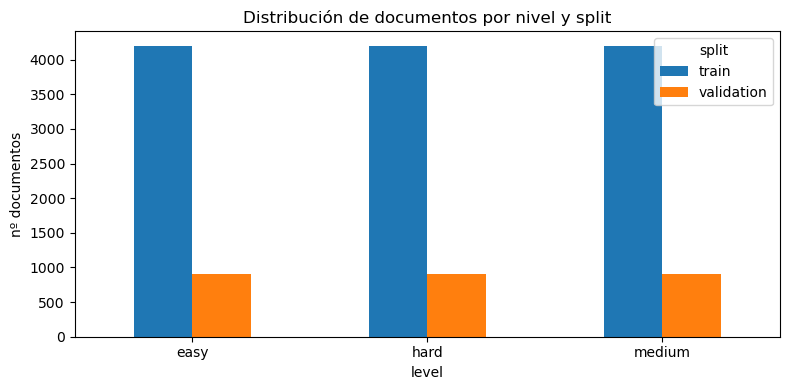

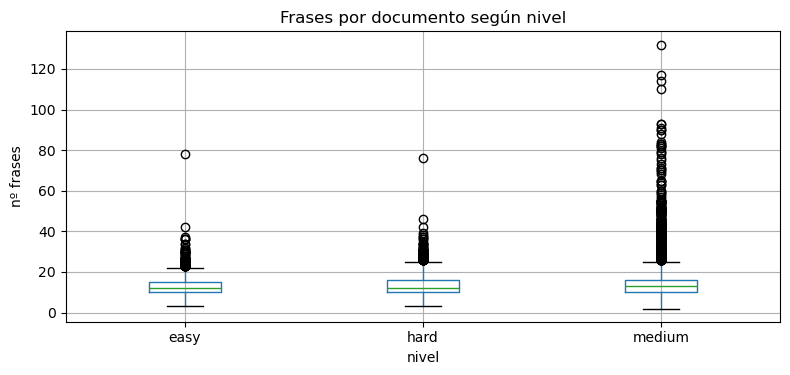

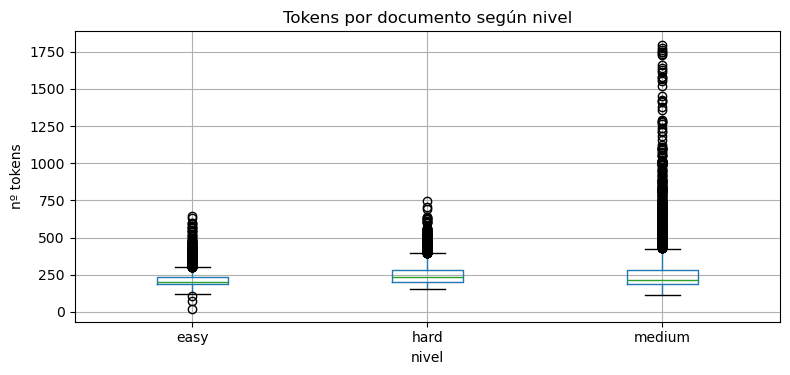

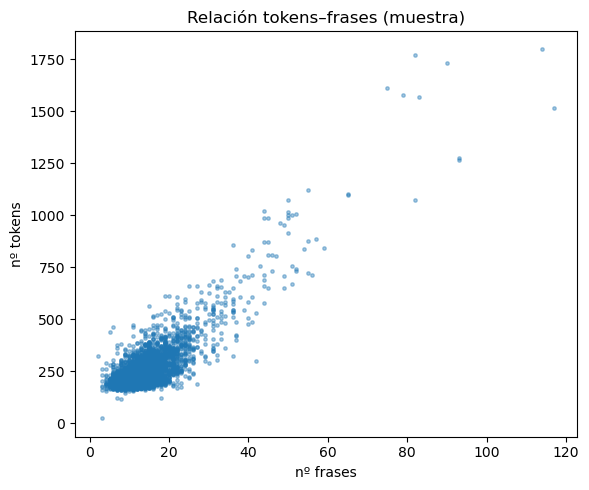

In [14]:
import matplotlib.pyplot as plt

# 6.1 Documentos por nivel y split
cnt = df_docs.groupby(["level","split"])["path"].count().reset_index(name="n_docs")
pivot_cnt = cnt.pivot(index="level", columns="split", values="n_docs").fillna(0)
ax = pivot_cnt.plot(kind="bar", figsize=(8,4), rot=0)
ax.set_ylabel("nº documentos")
ax.set_title("Distribución de documentos por nivel y split")
plt.tight_layout()
plt.savefig(REPORTS / "00_docs_por_nivel_split.png", dpi=150)
plt.show()

# 6.2 Boxplot frases por documento (todo el RAW)
ax = df_docs.boxplot(column="n_sentences_raw", by="level", figsize=(8,4))
plt.suptitle("")
ax.set_title("Frases por documento según nivel")
ax.set_xlabel("nivel")
ax.set_ylabel("nº frases")
plt.tight_layout()
plt.savefig(REPORTS / "00_boxplot_frases_por_nivel.png", dpi=150)
plt.show()

# 6.3 Boxplot tokens por documento
ax = df_docs.boxplot(column="n_tokens_raw", by="level", figsize=(8,4))
plt.suptitle("")
ax.set_title("Tokens por documento según nivel")
ax.set_xlabel("nivel")
ax.set_ylabel("nº tokens")
plt.tight_layout()
plt.savefig(REPORTS / "00_boxplot_tokens_por_nivel.png", dpi=150)
plt.show()

# 6.4 Dispersión tokens vs frases (muestreo para claridad)
muestra = df_docs.sample(min(5000, len(df_docs)), random_state=42)
plt.figure(figsize=(6,5))
plt.scatter(muestra["n_sentences_raw"], muestra["n_tokens_raw"], s=6, alpha=0.4)
plt.xlabel("nº frases")
plt.ylabel("nº tokens")
plt.title("Relación tokens–frases (muestra)")
plt.tight_layout()
plt.savefig(REPORTS / "00_scatter_tokens_vs_frases.png", dpi=150)
plt.show()